In [258]:
import os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as pth
from PIL.Image import *
from matplotlib import cm
from PIL import Image
import cv2
from PIL import Image
from sklearn.cluster import KMeans

In [1]:
import sys
import os
print(os.path.dirname(sys.executable))

C:\Anaconda


Time measuring :https://pynash.org/2013/03/06/timing-and-profiling/

## XZ image

## Pre-processing

In [260]:
def multiple_imshow(rows,cols,images ,titles):

    plt.figure(len(images), figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(rows,cols,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        #plt.xticks([]),plt.yticks([]) 
    plt.show()

def defect_detection(path,lower_bound,upper_bound,lower_bound_1 = [0,0,0],upper_bound_1 =[0,0,0]):
    
    img = cv2.imread(path,1)  # BGR color image reading and 0 flag for gray
    
    #blur = cv2.GaussianBlur(img,(5,5),0) #not good results
    #kernel = np.ones((5,5),np.float32)/25 #averaging is not satisfying as well
    #dst = cv2.filter2D(img,-1,kernel)
    #median = cv2.medianBlur(img,5)#median as well
    
    # converting it into Hue, saturation, value (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
   
    '''Threshold'''
    
    # define range of red color in HSV
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    
    # Threshold the HSV image to get only red colors
    mask_0 = cv2.inRange(hsv, lower, upper)
    mask_1 = cv2.inRange(hsv,np.array(lower_bound_1),np.array(upper_bound_1))
    mask =mask_0 + mask_1
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask = mask)
    
    return res


def pre_shaping(image,resol = [284,348]):
    
    #width = resol[1]
    #height = resol[0]
    #dim = (width, height) 
    
    # resize image
    #resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)#INTER_LINEAR_EXACT) 
    
    img = image
    rows,cols = img.shape
    
    frame = [[0,0],[cols,0],[0,rows],[cols,rows]]
    dimension = [[0,0],[resol[1],0],[0,resol[0]],[resol[1],resol[0]]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    resized = cv2.warpPerspective(img,M,(resol[1],resol[0]))
    
    return resized

def real_shaping(normalized_image,rows_dim,cols_dim,i = 8,j = 17):
    
    img = normalized_image
    rows,cols = img.shape
    
    frame = [[i,j],[rows,j],[i,cols],[rows,cols]]
    dimension = [[0,0],[cols_dim,0],[0,rows_dim],[cols_dim,rows_dim]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    real_shape = cv2.warpPerspective(img,M,(cols_dim,rows_dim))
    
    return real_shape

In [261]:
#%reset -f

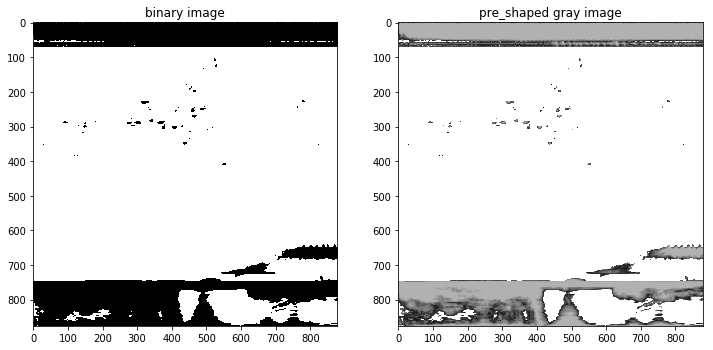

In [425]:
'''Functions call'''

path = "C:/Users/elh/Desktop/xz.png"

''' Big defects : red_yellow'''

lower_bound = [0,0,0]
upper_bound = [55,255,255] # for more defects the upper bound can go till ~105

res = defect_detection(path,lower_bound,upper_bound,[155,0,0],[179,255,255])

"""Binary image to detect the center"""
imgray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY) #convert to gray

#binary thresholding 
ret,thresh = cv2.threshold(imgray,0,1,cv2.THRESH_BINARY)
#th2 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            #cv2.THRESH_BINARY,11,2) #consider some defects as noise


title = 'Global Thresholding (big defects)'

'''shaping'''
#gray image

#img = pre_shaping(img,resol = [350,285])
images = [255-thresh,255-imgray]#255-img]#i,j --> y,x
titles = ['binary image','pre_shaped gray image']

multiple_imshow(1,2,images ,titles)


In [426]:
pre_processed_img = imgray # pre_shaped gray image

## Processing

In [427]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 260, stack, i, j, inComponent)
        
        defect.append((i,j))
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]>seuil and not inComponent[i,j]:
                baryAndSizes.append(connected_component_nb(image,seuil,i,j,inComponent))
                
    return baryAndSizes


def step2(image,defect_nb,thresh):
    
    imageR = image
    imageB = image

    baryAndSizesR = all_connected_components(imageR, thresh)
    baryAndSizesB = all_connected_components(imageB, thresh)
    
    xR, xB = np.array([],dtype=int), np.array([],dtype=int)
    yR, yB = np.array([],dtype=int), np.array([],dtype=int)
    sizeR, sizeB = np.array([]), np.array([]) 
    
    for i in range(len(baryAndSizesR)):
        xR = np.append(xR, baryAndSizesR[i][1][0])
        yR = np.append(yR, baryAndSizesR[i][1][1])
        sizeR = np.append(sizeR, baryAndSizesR[i][0])
    
    for i in range(len(baryAndSizesB)):
        xB = np.append(xB, baryAndSizesB[i][1][0])
        yB = np.append(yB, baryAndSizesB[i][1][1])
        sizeB = np.append(sizeB, baryAndSizesB[i][0])
    
    '''plot'''
    fig, ax = plt.subplots(1,3, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,imageR.shape[1])
    ax[1].set_xlim(0,imageB.shape[1])
    ax[2].set_xlim(0,imageB.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(yR, xR, marker='+', s=sizeR, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-imageB, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(yB, xB, marker='o', s=sizeB, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    '''defects list''' 
    #print(baryAndSizesB[0][2])#exemple of defect 0
    test = np.array([],dtype=int)
    test = baryAndSizesB[defect_nb][2] #i.e defect number 10
    test_x = np.ndarray(len(test))
    test_y = np.ndarray(len(test))
    for i in range(len(test)):
        test_x[i] = test[i][1] #x axis
        test_y[i] = test[i][0] #y axis
    
    ax[2].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[2].scatter(test_x, test_y, marker='o', s=1, c = 'b', alpha = 0.5)

    test = np.stack((test_x, test_y), axis=1)
    
    plt.show()
    
    return yR, xR, sizeR,test

In [428]:
'''smoothing for noise elimination'''
image = pre_processed_img
blur = cv2.GaussianBlur(image,(5,5),0) 

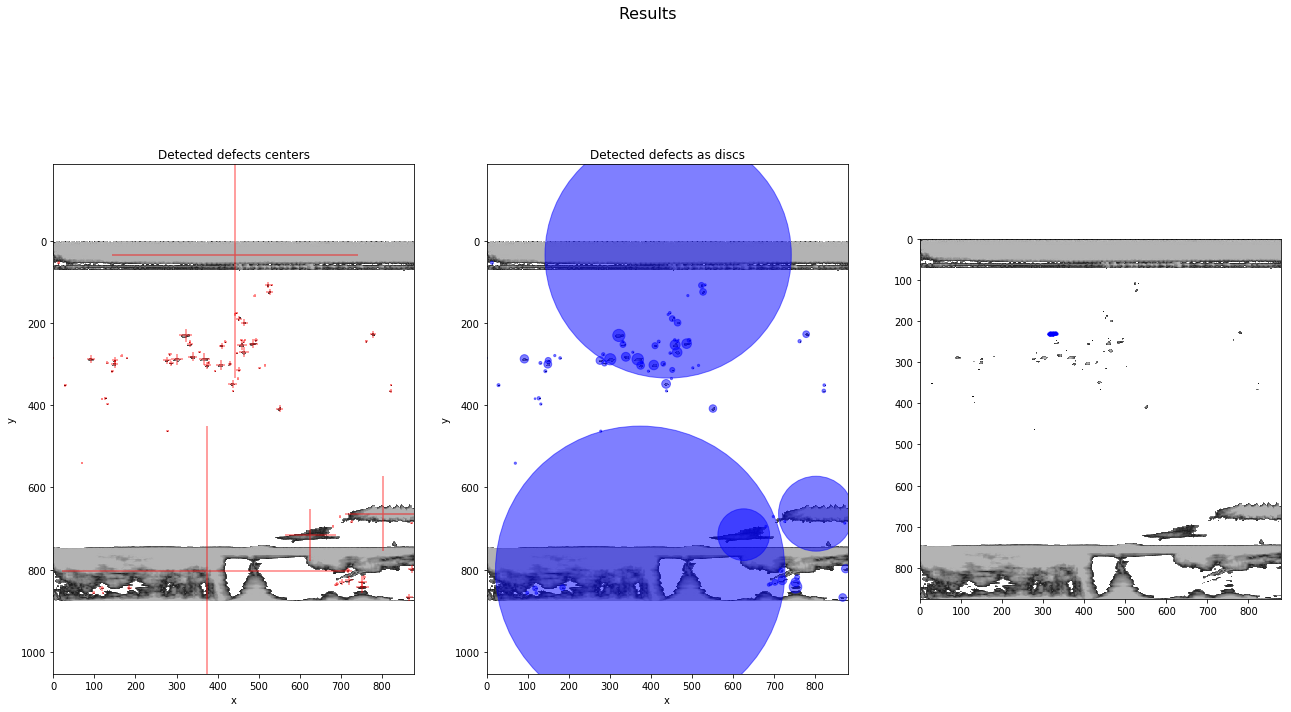

[[442  34]
 [ 13  53]
 [523 108]
 [532 107]
 [527 124]
 [490 133]
 [446 175]
 [442 179]
 [452 189]
 [465 199]
 [778 227]
 [322 230]
 [458 241]
 [467 241]
 [493 242]
 [762 244]
 [332 245]
 [419 245]
 [464 245]
 [487 250]
 [459 253]
 [332 252]
 [410 255]
 [464 271]
 [356 271]
 [447 273]
 [284 276]
 [166 279]
 [339 282]
 [  0 285]
 [ 92 287]
 [179 285]
 [301 288]
 [368 288]
 [150 291]
 [276 291]
 [378 296]
 [131 297]
 [149 300]
 [287 298]
 [430 299]
 [407 302]
 [375 303]
 [516 303]
 [502 309]
 [452 314]
 [143 317]
 [394 317]
 [450 335]
 [437 348]
 [ 29 351]
 [822 351]
 [438 365]
 [821 365]
 [127 383]
 [118 384]
 [132 397]
 [551 408]
 [278 463]
 [ 70 541]
 [802 664]
 [698 671]
 [726 683]
 [872 687]
 [626 715]
 [680 695]
 [374 803]
 [874 798]
 [717 802]
 [756 819]
 [720 826]
 [702 831]
 [752 831]
 [691 835]
 [687 837]
 [752 842]
 [185 844]
 [118 846]
 [ 99 857]
 [121 857]
 [867 868]]


In [429]:
'''Call function'''
image = pre_processed_img

x, y,area ,test= step2(image,11,0)
xy = np.stack((x, y), axis=1)
print xy


In [415]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

'''zoom function'''
def zoom(img,X,Y):
    
    """plot error"""
    f, ax = plt.subplots(1, figsize=(18,6))
    ax.imshow(255-img,cmap='gray')
    
    """zoom"""
    axins = zoomed_inset_axes(ax, 20, loc=2, bbox_to_anchor=(0,0))
    mark_inset(ax, axins, loc1=4, loc2=4, fc="none", ec="0.5")
    axins.set_xlim(X)
    axins.set_ylim(Y)
    
    plt.xticks(visible=False)
    plt.yticks(visible=False)

    """Plot zoom window"""
    axins.imshow(255-img,cmap='gray')
    
    plt.draw()
    plt.savefig("testondefect.jpg", dpi=150)
    plt.show()

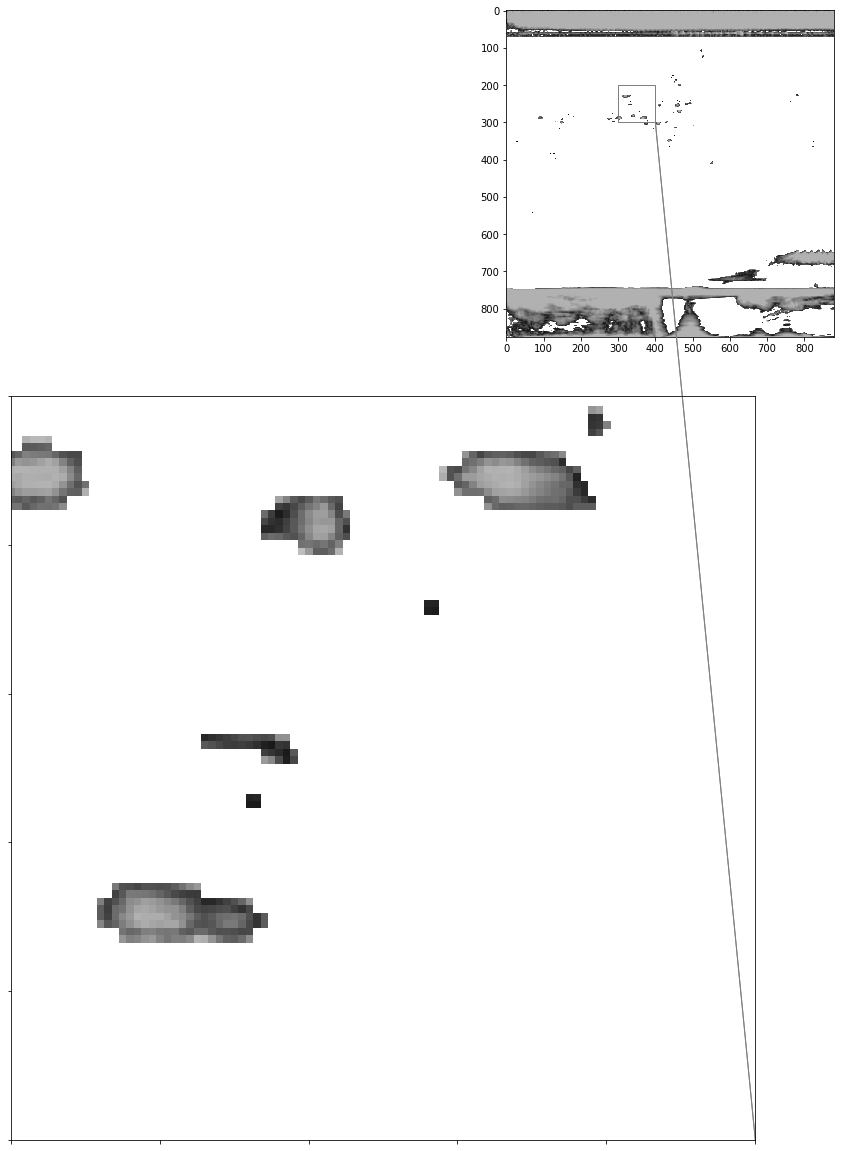

In [416]:
zoom(image,[300,400],[200,300])

In [417]:
np.array(test)
test

array([[315., 227.],
       [316., 227.],
       [317., 227.],
       [318., 227.],
       [319., 227.],
       [320., 227.],
       [321., 227.],
       [322., 227.],
       [323., 227.],
       [324., 227.],
       [325., 227.],
       [326., 227.],
       [327., 227.],
       [328., 227.],
       [329., 227.],
       [330., 227.],
       [331., 227.],
       [332., 227.],
       [332., 228.],
       [332., 229.],
       [333., 229.],
       [334., 229.],
       [334., 230.],
       [333., 230.],
       [331., 229.],
       [330., 229.],
       [329., 229.],
       [328., 229.],
       [327., 229.],
       [326., 229.],
       [325., 229.],
       [324., 229.],
       [323., 229.],
       [322., 229.],
       [321., 229.],
       [320., 229.],
       [319., 229.],
       [318., 229.],
       [317., 229.],
       [316., 229.],
       [315., 229.],
       [314., 229.],
       [313., 229.],
       [312., 229.],
       [312., 230.],
       [312., 231.],
       [313., 231.],
       [314.,

In [371]:
defect = test

In [372]:
defect.shape

(12L, 2L)

In [373]:
defect = test
defect = np.array(defect,dtype=np.uint64)

# Data extraction

## Post-processing

In [430]:
def post_processing(polygon,coordinates,area):
    old_dim = len(coordinates)
    p = pth.Path(polygon)
    mask = p.contains_points(coordinates)
    reduced_coord = coordinates[mask]
    reduced_area = area[mask]
    new_dim = len(reduced_coord)
    print(old_dim-new_dim,' values were reduced')
    return reduced_coord,reduced_area

def resizing(img,reduced_coord,dim):
    
    k_x = np.array(img.shape[1]/dim[0],dtype=float)
    k_y = np.array(img.shape[0]/dim[1],dtype=float)
    
    coord = reduced_coord.copy().astype(float)
    coord[:,0],coord[:,1] = reduced_coord[:,0]/k_x,reduced_coord[:,1]/k_y
    
    return coord
    

In [431]:
image.shape

(876L, 879L)

In [432]:
'''Function call'''
print image.shape
area = area
coordinates = xy
#polygon = np.array([[0,0],[image.shape[1],0],
            #[image.shape[1],image.shape[0]],[0,image.shape[0]]]) #x,y
    
polygon = np.array([[1,90],[image.shape[1],90],
            [image.shape[1],500],[1,500]]) #x,y (0,0)
                    
reduced_coord,reduced_area = post_processing(polygon,coordinates,area)

(876L, 879L)
(25, ' values were reduced')


In [433]:
'''Read the validation data with pandas'''

filepath="H:/Ali/_Internship/Validation/Anzeigen_Scheibe1_Segment1_Komponente1_2018-06-06.xlsx"# load demo.xlsx 
dataFrame = pd.read_excel(filepath, sheet_name = 'ESE_Nr.1')

xy_validation = dataFrame.iloc[112:,13:15].copy().as_matrix()
x_validation, y_validation = np.array(xy_validation[:,0]),np.array(xy_validation[:,1])

In [434]:
'''real coordinates'''
real_dimension = [280.,280.]

coord = resizing(imgray,reduced_coord,[280.,280.])


In [435]:
#import plotly.plotly as py
#import plotly.graph_objs as go

results data 56
validation data 40


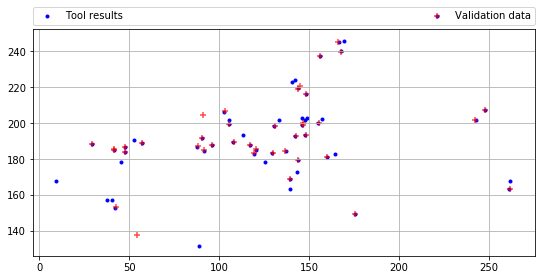

In [436]:
plt.figure(figsize=(9,6))
Tool_results = plt.scatter(coord[:,0],real_dimension[1]-coord[:,1],marker='.',c = 'b', alpha = 1)
Validation = plt.scatter(x_validation,real_dimension[1]-y_validation, marker='+', c = 'r', alpha = 0.7)
plt.legend([Tool_results , (Tool_results , Validation)], ["Tool results", "Validation data"],
           #bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.)
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2,mode='expand', borderaxespad=0.)
#plt.xlim(0, 300.)
#plt.ylim(0, 300.)
plt.gca().set_aspect('equal', adjustable='box')
#plt.title('Validation')
plt.grid()
plt.savefig('validation.png')

print('results data %d' % len(coord))
print('validation data %d' % len(x_validation))

In [381]:
reduced_coord[:,0]

array([523, 532, 527, 447, 453, 465, 778, 322, 458, 493, 762, 332, 419,
       464, 487, 459, 332, 410, 464, 356, 284, 166, 339,  92, 180, 301,
       368, 150, 276, 378, 131, 149, 287, 407, 429, 375, 516, 452, 143,
       394, 437,  29, 822, 438, 820, 127, 548, 540, 551, 278])

In [382]:
x_validation

array([29.4915254237288, 47.7966101694915, 88.135593220339,
       155.593220338983, 96.271186440678, 129.830508474576,
       139.322033898305, 47.7966101694915, 41.6949152542373,
       41.6949152542373, 57.2881355932203, 175.593220338983,
       146.440677966102, 148.135593220339, 117.28813559322,
       103.050847457627, 119.661016949153, 108.474576271186,
       105.762711864407, 130.847457627119, 91.864406779661,
       90.8474576271186, 90.5084745762712, 120.677966101695,
       136.949152542373, 144.067796610169, 142.71186440678,
       143.728813559322, 145.084745762712, 148.135593220339,
       146.440677966102, 160.338983050847, 166.440677966102,
       167.796610169492, 156.271186440678, 248.135593220339,
       242.71186440678, 261.694915254237, 42.3728813559322,
       54.5762711864407], dtype=object)

## export

In [440]:
from openpyxl import load_workbook

In [441]:
xy = pd.DataFrame({'X':coord[:,0],'Z':coord[:,1]})


In [442]:
path = r'C:\Users\elh\Desktop\Intership project\myenv\komponent_1_output.xlsx'

book = load_workbook(path)
writer = pd.ExcelWriter(path,engine = 'openpyxl')
writer.book = book

xy.to_excel(writer,sheet_name='xz coordinates')  

writer.save()
writer.close()

# Ellipse

In [72]:
case = case_0.copy()

In [73]:
im = np.empty(case.shape, dtype=np.bool)
im[:,:] = 0
im[np.where(case>0)]= 1
im = im*1

In [74]:
ret,thresh = cv2.threshold(case,0,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)

cnt = contours[0]

In [75]:
(x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
#llipse = cv2.fitEllipse(cnt)
#im = cv2.ellipse(case_0,ellipse,(0,255,0),2)
#plt.imshow(im)
(x,y)
(MA,ma)
#angle

(17.514001846313477, 31.838390350341797)

In [76]:
angle = np.angle(-1+1j, deg=True)
angle

135.0

In [77]:
https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
https://matplotlib.org/3.1.0/gallery/units/ellipse_with_units.html#sphx-glr-gallery-units-ellipse-with-units-py

SyntaxError: invalid syntax (<ipython-input-77-ad3738699b92>, line 1)